# VQVAE with Residual Stack

In [1]:
import os

from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.metrics import MAE
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import datetime

In [2]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
(x_train, _), (x_test, _) = cifar10.load_data()

# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

Define the parameters

In [10]:
input_shape = x_train.shape[1:]
num_hiddens = 128
num_residual_layers = 4
num_residual_hiddens = 32
data_variance = np.var(x_train / 255.0)
embedding_dim = 15
num_embeddings = 256  #512
learning_rate = 3e-4

Initialize a VQVAETrainer

In [12]:
from app.networks.vqvae import VQVAETrainer

vqvae_trainer = VQVAETrainer(
    input_shape=input_shape,
    num_hiddens=num_hiddens,
    num_residual_layers=num_residual_layers,
    num_residual_hiddens=num_residual_hiddens,
    train_variance=data_variance,
    latent_dim=embedding_dim,
    num_embeddings=num_embeddings,
    name='VQVAETrainer'
)

In [13]:
vqvae_trainer.vqvae.summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 Encoder (Encoder)           (None, 8, 8, 15)          449359    
                                                                 
 vector_quantizer (VectorQua  (None, 8, 8, 15)         3840      
 ntizer)                                                         
                                                                 
 Decoder (Decoder)           (None, 32, 32, 3)         316611    
                                                                 
Total params: 769,810
Trainable params: 769,042
Non-trainable params: 768
_________________________________________________________________


Compile the network

In [14]:
from pathlib import Path

ROOT = Path(os.getcwd()).parent
DIR_FIT = os.path.join(ROOT, '.logs', 'fit')

In [15]:
log_dir = os.path.join(DIR_FIT, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Tensorboard

In [16]:
# code block: %tensorboard --logdir .logs/fit
# cmd: tensorboard --logdir .logs/fit

In [17]:
vqvae_trainer.compile(optimizer=Adam(learning_rate=learning_rate))

Train the network

In [18]:
history = vqvae_trainer.fit(x_train_scaled,
                            epochs=100,
                            batch_size=128,
                            callbacks=[tensorboard_callback])

Epoch 1/100
391/391 [==============================] - 14s 20ms/step - loss: 69.5596 - reconstruction_loss: 0.4369 - vqvae_loss: 68.9880
Epoch 2/100
391/391 [==============================] - 8s 20ms/step - loss: 67.3428 - reconstruction_loss: 0.3117 - vqvae_loss: 66.9793
Epoch 3/100
391/391 [==============================] - 8s 19ms/step - loss: 4.0685 - reconstruction_loss: 0.3314 - vqvae_loss: 3.7683
Epoch 4/100
391/391 [==============================] - 8s 20ms/step - loss: 11.7445 - reconstruction_loss: 0.2981 - vqvae_loss: 11.4254
Epoch 5/100
391/391 [==============================] - 8s 20ms/step - loss: 8.5574 - reconstruction_loss: 0.2933 - vqvae_loss: 8.2667
Epoch 6/100
391/391 [==============================] - 8s 19ms/step - loss: 1.2737 - reconstruction_loss: 0.2168 - vqvae_loss: 1.0448
Epoch 7/100
391/391 [==============================] - 8s 19ms/step - loss: 0.6918 - reconstruction_loss: 0.1930 - vqvae_loss: 0.4963
Epoch 8/100
391/391 [==============================] - 

Plot performance of the network

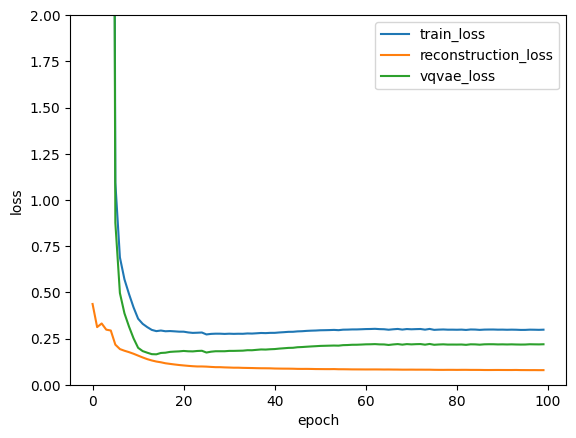

In [19]:
pd.DataFrame({
    'train_loss': history.history["loss"],
    'reconstruction_loss': history.history["reconstruction_loss"],
    'vqvae_loss': history.history["vqvae_loss"]}).plot(ylabel='loss', xlabel='epoch')
plt.ylim(0, 2);

In [20]:
vqvae_model = vqvae_trainer.vqvae

In [21]:
encoder = vqvae_model.get_layer("Encoder")
quantizer = vqvae_model.get_layer("vector_quantizer")
decoder = vqvae_model.get_layer('Decoder')

In [22]:
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
test_images.shape

(10, 32, 32, 3)

In [24]:
def get_code_indices(flattened_inputs, embeddings):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [23]:
encoded_outputs = encoder.predict(test_images)
encoded_outputs.shape

1/1 [==============================] - 1s 961ms/step


(10, 8, 8, 15)

In [25]:
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
flat_enc_outputs.shape, quantizer.embeddings.shape

((640, 15), TensorShape([15, 256]))

In [26]:
codebook_indices = get_code_indices(flat_enc_outputs, quantizer.embeddings)

In [27]:
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

In [28]:
quantized = quantizer(encoded_outputs)
quantized.shape

TensorShape([10, 8, 8, 15])

In [29]:
flattened = tf.reshape(quantized[0], [-1])
flattened.shape, 32 * 32 * 3

(TensorShape([960]), 3072)

In [30]:
reconstructed = decoder.predict(quantized)
reconstructed.shape

1/1 [==============================] - 0s 277ms/step


(10, 32, 32, 3)

In [32]:
i = 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


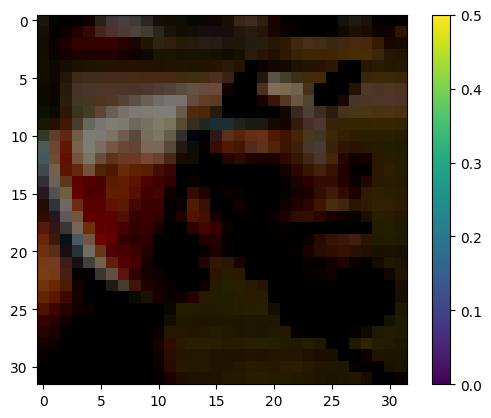

In [33]:
plt.imshow(test_images[i])
plt.colorbar();

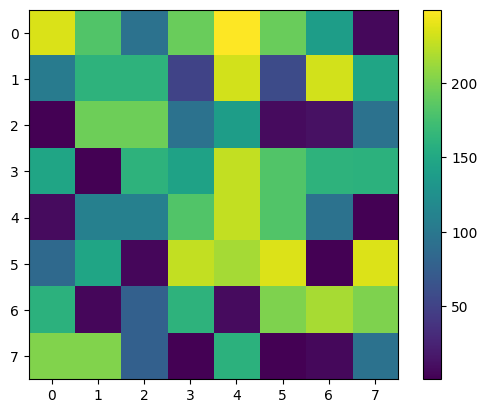

In [34]:
plt.imshow(codebook_indices[i])
plt.colorbar();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


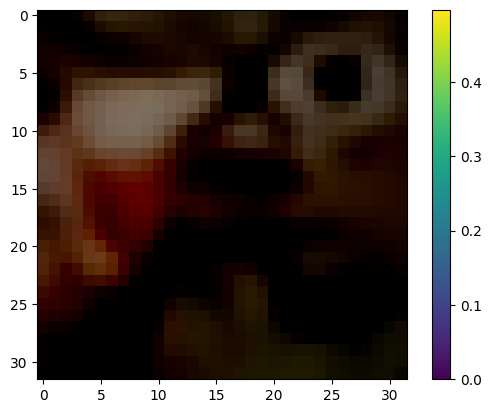

In [35]:
plt.imshow(reconstructed[i])
plt.colorbar();

In [36]:
mean_absolute_error = MAE(test_images[i].flatten(), reconstructed[i].flatten())
mean_absolute_error = np.round(mean_absolute_error.numpy(), 3)
mean_absolute_error

0.068